In [1]:
!nvidia-smi

Fri Jul  9 21:25:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8     8W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [1]:
#pip3 install -U h5py==2.9.0
#pip3 install -U gast==0.4.0
#!pip3 install -U scikit-learn==0.20
#!pip3 install -U attention

In [2]:
#import sklearn
#import tensorflow as tf
#print(tf.__version__)
#print(sklearn.__version__)

In [3]:
#!pip3 install -U jupyter

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pickle import dump,load

In [2]:
import os
import time
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
from sodapy import Socrata

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
from attention import Attention

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [10]:
#from tensorflow.python.client import device_lib

#device_lib.list_local_devices()
#tf.test.is_gpu_available()
#gpu_available = tf.test.is_gpu_available()
#is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
#is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
#print(gpu_available, is_cuda_gpu_available, is_cuda_gpu_min_3)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
#Load data

In [7]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


In [8]:
#COLLECT DATA

In [9]:
#Incidencia - Regio

In [19]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2022-03-02


In [20]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("dmzh-fz47",limit=1000000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(665941, 13)


In [21]:
print(results_df.columns)
results_df["data"] = pd.to_datetime(results_df["data"])

#Ingressats_critic -> UCI (ocupat)
#Ingressats_total -> Planta+UCI (ocupat)


results_df["casos_confirmat"] = pd.to_numeric(results_df["casos_confirmat"])
results_df["ingressos_critic"] = pd.to_numeric(results_df["ingressos_critic"])
results_df["ingressos_total"] = pd.to_numeric(results_df["ingressos_total"])
results_df["ingressats_critic"] = pd.to_numeric(results_df["ingressats_critic"])
results_df["ingressats_total"] = pd.to_numeric(results_df["ingressats_total"])

#results_df.sort_values("data",ascending=True).tail()
dfCasosReg = results_df[["data","nom","codi","casos_confirmat",
                         "ingressos_critic","ingressos_total",
                         "ingressats_critic","ingressats_total"
                         ]].groupby([
    "data","nom","codi"]).sum() #
print(dfCasosReg.columns)
dfCasosReg = dfCasosReg.reset_index()
print(dfCasosReg.shape)
dfCasosReg.tail(50)

Index(['nom', 'codi', 'data', 'sexe', 'grup_edat', 'residencia',
       'casos_confirmat', 'pcr', 'ingressos_total', 'ingressos_critic',
       'ingressats_total', 'ingressats_critic', 'exitus'],
      dtype='object')
Index(['casos_confirmat', 'ingressos_critic', 'ingressos_total',
       'ingressats_critic', 'ingressats_total'],
      dtype='object')
(32164, 8)


,data,nom,codi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total
32114,2022-02-28,SELVA MARÍTIMA,56,27,0,0,3,13
32115,2022-02-28,Sense especificar,SES,92,1,2,26,94
32116,2022-02-28,TARRAGONÈS,9,204,0,3,8,43
32117,2022-02-28,VALLÈS OCCIDENTAL EST,35,211,5,4,16,68
32118,2022-02-28,VALLÈS OCCIDENTAL OEST,66,232,0,6,8,81
32119,2022-02-28,VALLÈS ORIENTAL CENTRAL,69,76,0,16,2,30
32120,2022-03-01,ALT CAMP I CONCA DE BARBERÀ,6,19,0,0,3,10
32121,2022-03-01,ALT EMPORDÀ,51,35,0,0,6,22
32122,2022-03-01,ALT MARESME,55,62,0,0,3,20
32123,2022-03-01,ALT PENEDÈS,61,34,0,3,5,22


In [22]:
mapRegId =  {'0000': 'No classificat',
 '7803': 'BARCELONA CIUTAT',
 '6700': 'CATALUNYA CENTRAL',
 '7801': 'METROPOLITANA SUD',
 '6400': 'GIRONA',
 '7802': 'METROPOLITANA NORD',
 '6200': 'CAMP DE TARRAGONA',
 '6100': 'LLEIDA',
 '7100': 'ALT PIRINEU I ARAN',
 '6300': "TERRES DE L'EBRE"}

In [25]:
regions={
"7100":[1,2,3,4,37,103,169,174,179,180,233,259],
"7803":[16,17,18,20,71,72,73,74,75,76,77,78,79,331,39,40,41,32,34,36,38,381,
        400,42,43,44,45,46,21,23,27,28,29,31,47,358,
        326,327,385,402,403,70,395,396],
"7801":[24,25,61,62,63,64,65,176,218,235,316,317,359,380,393,394,397,398,108,109,110,111,116,117,122,123,
        160,182,183,184,202,203,204,205,209,210,213,214,216,261,265,266,288,289,290,291,
        292,293,294,295,296,297,298,299,368,369,370,
        374,378,379,401,115,149,168,201,360,365,367],
"7802":[10,30,33,35,55,66,67,68,69,152,153,154,155,156,157,158,186,222,223,224,225,226,271,272,273,274,275,
        276,277,279,280,281,282,283,311,312,319,335,341,342,353,361,362,366,97,104,105,190,
        191,192,193,194,196,197,198,320,322,344,345,382,383,384,386,387,392,247,248,249,250,
        251,252,309,310,356,363,377,388,389,390,399,89,95,121,150,164,175,207,230,284,285,
        286,
        287,300,315,348,349,355,373,391],
"6200":[6,7,8,9,48,162,262,263,333,13,107,166,239,240,241,242,243,244,257,314,339,340,350,357,364,
        87,91, 112,118,163,188,303,304,306,305,307,324,354],
"6700":[19,22,59,60,88,131,228,229,269,337,338,371,372,102,144,185,212,217,238,253,254,351,352,376,11,
        82,96,98,128,130,145,146,147,148,159,167,200,211,215,219,236,237],
"6400":[51,52,53,54,56,57,58,80,83,84,92,114,119,133,134,171,172,173,177,187,189,208,258,267,343,346,347,
        15,85,90,93,100,101,124,125,126,127,142,143,199,221,231,234,325,330,336],
"6100":[5,12,14,81,86,106,129,135,136,137,138,139,140,141,161,181,232,245,329,334,375],
"6300":[49,50,113,120,165,178,206,246,255,256,260,328],
"SES": []
}

In [27]:
dfCasosReg = dfCasosReg[dfCasosReg["codi"]!="SES"]
dfCasosReg["codi"] = pd.to_numeric(dfCasosReg["codi"])
dfCasosReg["regiosanitariacodi"] = -1
for reg in regions.keys():
    for r in regions[reg]:
        dfCasosReg["regiosanitariacodi"].loc[dfCasosReg["codi"].values == r] = reg
    
#Save
dfCasosReg.to_csv("data_flow/CASOS_UCI" + today +".csv",index=False)
print(dfCasosReg.shape)
dfCasosReg.loc[dfCasosReg["regiosanitariacodi"]==-1][["nom","codi","regiosanitariacodi"]]

/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(31433, 9)


,nom,codi,regiosanitariacodi


In [64]:
#Vacunacio - Regio

In [28]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tp23-dey4",limit=10000000) #623z-r97q

In [29]:
#'BioNTech / Pfizer' 'No administrada' 'Moderna / Lonza'
#'Oxford / AstraZeneca' 'J&J / Janssen'
fabDosi = dict()
fabDosi["BioNTech / Pfizer"] = 2
fabDosi["Moderna / Lonza"] = 2
fabDosi["Oxford / AstraZeneca"] = 2
fabDosi["J&J / Janssen"] = 1

In [30]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df["regio_codi"][results_df["regio_codi"].isnull()] = 0

print(results_df.columns)
print(results_df.shape)
print(results_df["regio"].unique())
print(results_df["regio_codi"].unique())
print(results_df["fabricant"].unique())
print(results_df["dosi"].unique())

Index(['sexe_codi', 'sexe', 'regio_codi', 'regio', 'sector_codi', 'sector',
       'aga_codi', 'aga', 'abs_codi', 'abs', 'edat', 'dosi', 'data',
       'fabricant', 'recompte', 'no_vacunat'],
      dtype='object')
(3720349, 16)
['BARCELONA CIUTAT' 'METROPOLITANA NORD' 'METROPOLITANA SUD' 'GIRONA'
 'CATALUNYA CENTRAL' 'CAMP DE TARRAGONA' 'LLEIDA' "TERRES DE L'EBRE"
 'ALT PIRINEU I ARAN' 'No classificat']
['7803' '7802' '7801' '6400' '6700' '6200' '6100' '6300' '7100' 0]
['Moderna / Lonza' 'BioNTech / Pfizer' 'Oxford / AstraZeneca'
 'J&J / Janssen' 'No administrada']
['1' '2' '3']


In [31]:
results_df["no_vacunat"][results_df["no_vacunat"].isnull()] = 0
results_df["no_vacunat"][results_df["no_vacunat"]!=0] = 1

print(results_df["no_vacunat"].unique())

results_df["data"] = pd.to_datetime(results_df["data"])
results_df["recompte"] = pd.to_numeric(results_df["recompte"])
results_df["dosi"] = pd.to_numeric(results_df["dosi"])
results_df["no_vacunat"] = pd.to_numeric(results_df["no_vacunat"])

dfCasosVac = results_df[["data","regio_codi","regio","dosi","no_vacunat","recompte"]].groupby([
    "data","regio_codi","regio","dosi","no_vacunat"]).sum()
print(dfCasosVac.shape)
dfCasosVac = dfCasosVac.reset_index()
dfCasosVac = dfCasosVac[dfCasosVac["no_vacunat"]==0]
dfCasosVac.to_csv("data_flow/CASOS_VAC" + today +".csv",index=False)
print(dfCasosVac.shape)
dfCasosVac

[0 1]
(17930, 1)
(9539, 6)


,data,regio_codi,regio,dosi,no_vacunat,recompte
0,2020-12-27,6100,LLEIDA,1,0,68
1,2020-12-27,6200,CAMP DE TARRAGONA,1,0,112
3,2020-12-27,6300,TERRES DE L'EBRE,1,0,82
4,2020-12-27,6400,GIRONA,1,0,76
5,2020-12-27,6700,CATALUNYA CENTRAL,1,0,87
...,...,...,...,...,...,...
17920,2022-02-28,7802,METROPOLITANA NORD,2,0,1168
17922,2022-02-28,7802,METROPOLITANA NORD,3,0,990
17924,2022-02-28,7803,BARCELONA CIUTAT,1,0,68
17926,2022-02-28,7803,BARCELONA CIUTAT,2,0,929


In [32]:
dfCasosVac["regio_codi"].unique()

array(['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802',
       '7803', 0], dtype=object)

In [33]:
dfCasosVac["regio"].unique()

array(['LLEIDA', 'CAMP DE TARRAGONA', "TERRES DE L'EBRE", 'GIRONA',
       'CATALUNYA CENTRAL', 'ALT PIRINEU I ARAN', 'METROPOLITANA SUD',
       'METROPOLITANA NORD', 'BARCELONA CIUTAT', 'No classificat'],
      dtype=object)

In [34]:
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==1].sum())
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==0].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==1)].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==2)].sum())

0
15507997
6482117
5796144


In [ ]:
#LOAD

In [6]:
#today = "2021-05-27" #TRAIN
#today = "2021-12-02"
today = '2022-03-02'

In [7]:
#Vacunats

In [8]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)
#dfVac[dfVac["regio_codi"]==7803][["data","recompte"]].plot(x="data",y="recompte") #BCN CENTRE
#dfVac[dfVac["regio_codi"]==7801][["data","recompte"]].plot(x="data",y="recompte") #BCN SUD
#dfVac[dfVac["regio_codi"]==7802][["data","recompte"]].plot(x="data",y="recompte") #BCN NORD


(9539, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
9534    2022-02-28
9535    2022-02-28
9536    2022-02-28
9537    2022-02-28
9538    2022-02-28
Name: data, dtype: object
935
[1 2 3]
(997, 6)


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(413, 2) (426, 2) (421, 2) (423, 2) (418, 2) (426, 2) (413, 2) (398, 2) (380, 2) (398, 2)


In [10]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [11]:
#dfVacAll.plot(x="data", figsize=(15,8))

In [12]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,19.0,1127.0,419.0,1222.0,794.0,1245.0,667.0,318.0,28.0,113.0
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,16.0,1387.0,514.0,1082.0,969.0,1393.0,508.0,439.0,27.0,194.0
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,11.0,1596.0,433.0,1557.0,627.0,1227.0,522.0,320.0,14.0,150.0
411,2022-02-26,60,24.0,NaN,123.0,4.0,141,4.0,NaN,NaN,...,NaN,345.0,24.0,1219.0,15.0,1431.0,524.0,1.0,NaN,32.0
412,2022-02-28,41,68.0,23.0,71.0,30.0,86,7.0,32.0,10.0,...,4.0,929.0,129.0,1079.0,310.0,1168.0,490.0,264.0,28.0,140.0


In [13]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     3
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    18
recompte_r_7100_v1    36
recompte_r_6300_v1    19
recompte_r_0_v2       43
recompte_r_7803_v2    22
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    39
recompte

In [14]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,68.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,173,441.0,295.0,401.0,127.0,648,16.0,364.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,191,665.0,228.0,231.0,80.0,569,4.0,504.0,112.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,602.0,401.0,111.0,234.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,468.285714,1122.428571,342.000000,1042.428571,669.285714,1336.000000,17.571429,296.571429,48.571429,95.142857
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,479.285714,1166.285714,353.142857,1044.142857,703.142857,1290.571429,16.428571,308.285714,39.857143,104.428571
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,495.428571,1211.714286,355.571429,1125.285714,662.714286,1199.857143,14.000000,307.000000,26.000000,100.000000
411,2022-02-26,60,24.0,0.0,123.0,4.0,141,4.0,0.0,0.0,...,479.571429,1026.571429,271.857143,1118.571429,534.857143,1187.857143,10.857143,224.857143,22.714286,85.428571


In [15]:
#Incidence x regio

In [16]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc.tail()

,data,nom,codi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total,regiosanitariacodi
31428,2022-03-01,SELVA MARÍTIMA,56,21,0,0,3,11,6400
31429,2022-03-01,TARRAGONÈS,9,102,0,4,8,42,6200
31430,2022-03-01,VALLÈS OCCIDENTAL EST,35,107,0,0,15,66,7802
31431,2022-03-01,VALLÈS OCCIDENTAL OEST,66,113,0,0,7,79,7802
31432,2022-03-01,VALLÈS ORIENTAL CENTRAL,69,58,0,0,2,24,7802


In [17]:
#group by date and regiosanitaria
dfInc = dfInc[["data","casos_confirmat","ingressos_critic","ingressos_total","ingressats_critic",
              "ingressats_total","regiosanitariacodi"]]
grp = dfInc.groupby(["data","regiosanitariacodi"]).agg("sum")
dfInc = grp.reset_index()
dfInc

,data,regiosanitariacodi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total
0,2020-03-01,6100,0,0,0,0,0
1,2020-03-01,6200,0,0,0,0,0
2,2020-03-01,6300,0,0,0,0,0
3,2020-03-01,6400,2,0,0,0,0
4,2020-03-01,6700,0,0,0,0,0
...,...,...,...,...,...,...,...
6574,2022-03-01,6700,172,0,0,14,100
6575,2022-03-01,7100,26,0,0,0,8
6576,2022-03-01,7801,365,0,3,26,174
6577,2022-03-01,7802,616,3,0,54,337


In [18]:
print(dfInc.shape)
print(dfInc.columns)
print(dfInc["regiosanitariacodi"].unique())
print(dfInc["data"].iloc[-5:])
print((dfInc["regiosanitariacodi"]==0).sum())


dfInc["casos_confirmat"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["ingressos_critic"] = pd.to_numeric(dfInc["ingressos_critic"])
dfInc["ingressos_total"] = pd.to_numeric(dfInc["ingressos_total"])
dfInc["ingressats_critic"] = pd.to_numeric(dfInc["ingressats_critic"])
dfInc["ingressats_total"] = pd.to_numeric(dfInc["ingressats_total"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc.sort_values("data",ascending=True, inplace=True)

(6579, 7)
Index(['data', 'regiosanitariacodi', 'casos_confirmat', 'ingressos_critic',
       'ingressos_total', 'ingressats_critic', 'ingressats_total'],
      dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803]
6574    2022-03-01
6575    2022-03-01
6576    2022-03-01
6577    2022-03-01
6578    2022-03-01
Name: data, dtype: object
0


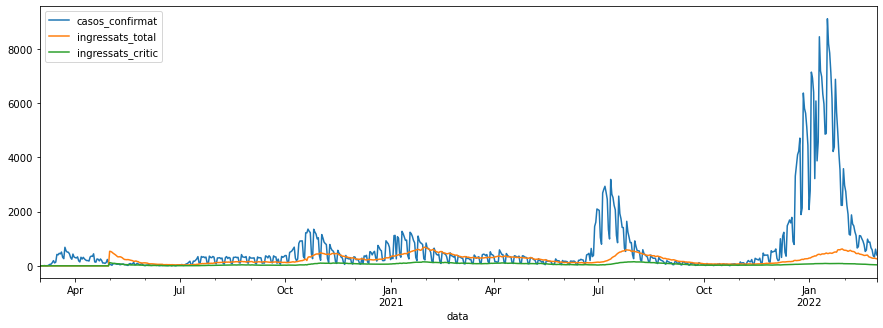

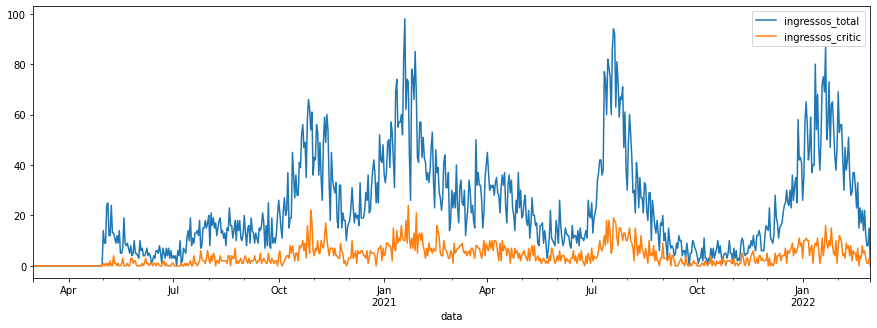

In [19]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
dfInc.loc[dfInc["regiosanitariacodi"]==7803][["data","casos_confirmat"]].plot(x="data",ax=ax)
dfInc.loc[dfInc["regiosanitariacodi"]==7803][["data","ingressats_total"]].plot(x="data",ax=ax)
dfInc.loc[dfInc["regiosanitariacodi"]==7803][["data","ingressats_critic"]].plot(x="data",ax=ax)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
dfInc.loc[dfInc["regiosanitariacodi"]==7803][["data","ingressos_total"]].plot(x="data",ax=ax)
dfInc.loc[dfInc["regiosanitariacodi"]==7803][["data","ingressos_critic"]].plot(x="data",ax=ax)
plt.legend()
plt.show()

In [20]:
# Tranform data
#dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","ingressats_critic"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","ingressos_total","casos_confirmat"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","ingressos_total","casos_confirmat"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","ingressos_total","casos_confirmat"]]
print(dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

#dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
dfInc = pd.merge(dfInc_r_7803,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_6300","_r_6300_1"))

dfInc = dfInc[['data', 
       'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300',
       'ingressos_total_r_7803', 'ingressos_total_r_6700',
       'ingressos_total_r_7801', 'ingressos_total_r_6400',
       'ingressos_total_r_7802', 'ingressos_total_r_6200',
       'ingressos_total_r_6100', 'ingressos_total_r_7100',
       'ingressos_total_r_6300'               
              ]]
print(dfInc.shape)
print(dfInc.columns)
dfInc.tail(50)

(731, 3) (731, 3) (731, 3)
(731, 19)
Index(['data', 'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300', 'ingressos_total_r_7803',
       'ingressos_total_r_6700', 'ingressos_total_r_7801',
       'ingressos_total_r_6400', 'ingressos_total_r_7802',
       'ingressos_total_r_6200', 'ingressos_total_r_6100',
       'ingressos_total_r_7100', 'ingressos_total_r_6300'],
      dtype='object')


,data,casos_confirmat_r_7803,casos_confirmat_r_6700,casos_confirmat_r_7801,casos_confirmat_r_6400,casos_confirmat_r_7802,casos_confirmat_r_6200,casos_confirmat_r_6100,casos_confirmat_r_7100,casos_confirmat_r_6300,ingressos_total_r_7803,ingressos_total_r_6700,ingressos_total_r_7801,ingressos_total_r_6400,ingressos_total_r_7802,ingressos_total_r_6200,ingressos_total_r_6100,ingressos_total_r_7100,ingressos_total_r_6300
681,2022-01-11,7188,2321,6469,3174,9920,2520,1517,273,577,40,40,68,38,92,32,13,2,5
682,2022-01-12,6983,2293,5914,3263,9880,2411,1421,283,624,80,36,75,27,95,25,13,3,7
683,2022-01-13,6338,2149,5579,3044,9498,2256,1384,243,489,54,37,72,31,105,20,17,3,4
684,2022-01-14,5973,2191,5344,3151,9342,2220,1294,251,515,68,32,57,29,110,21,18,2,1
685,2022-01-15,4859,1776,3952,2523,7949,1877,1125,227,432,47,35,56,21,87,22,17,2,7
686,2022-01-16,4883,1869,4505,2707,8387,2015,1248,182,519,38,34,46,30,68,16,13,1,5
687,2022-01-17,9118,3456,8552,4872,14557,3495,2015,348,736,51,34,70,34,105,32,20,4,4
688,2022-01-18,8194,3157,7421,4423,13622,3311,1971,348,729,72,63,64,36,116,27,20,5,5
689,2022-01-19,7852,2998,7148,4353,12973,3323,1886,279,669,75,33,75,27,113,29,11,1,3
690,2022-01-20,7140,2607,6519,3952,11411,3317,1841,238,686,69,41,62,35,85,19,10,5,5


In [21]:
#NAN
print(dfInc.isnull().sum(axis=0))
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data                      0
casos_confirmat_r_7803    0
casos_confirmat_r_6700    0
casos_confirmat_r_7801    0
casos_confirmat_r_6400    0
casos_confirmat_r_7802    0
casos_confirmat_r_6200    0
casos_confirmat_r_6100    0
casos_confirmat_r_7100    0
casos_confirmat_r_6300    0
ingressos_total_r_7803    0
ingressos_total_r_6700    0
ingressos_total_r_7801    0
ingressos_total_r_6400    0
ingressos_total_r_7802    0
ingressos_total_r_6200    0
ingressos_total_r_6100    0
ingressos_total_r_7100    0
ingressos_total_r_6300    0
dtype: int64
data                      0
casos_confirmat_r_7803    0
casos_confirmat_r_6700    0
casos_confirmat_r_7801    0
casos_confirmat_r_6400    0
casos_confirmat_r_7802    0
casos_confirmat_r_6200    0
casos_confirmat_r_6100    0
casos_confirmat_r_7100    0
casos_confirmat_r_6300    0
ingressos_total_r_7803    0
ingressos_total_r_6700    0
ingressos_total_r_7801    0
ingressos_total_r_6400    0
ingressos_total_r_7802    0
ingressos_total_r_6200    0
ingress

In [22]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = [
       'data',
       'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
       'casos_confirmat_r_7801', 'casos_confirmat_r_6400',
       'casos_confirmat_r_7802', 'casos_confirmat_r_6200',
       'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
       'casos_confirmat_r_6300',    
       'ingressos_total_r_7803', 'ingressos_total_r_6700',
       'ingressos_total_r_7801', 'ingressos_total_r_6400',
       'ingressos_total_r_7802', 'ingressos_total_r_6200',
       'ingressos_total_r_6100', 'ingressos_total_r_7100',
       'ingressos_total_r_6300'
]
print(cols)
dfInc = dfInc[cols]
for k in range(1,len(cols)):
    print(k,cols[k])
    dfInc[cols[k]] = pd.to_numeric(dfInc[cols[k]])
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
               'casos_confirmat_r_7803', 'casos_confirmat_r_6700',
               'casos_confirmat_r_7801', 'casos_confirmat_r_6400', 'casos_confirmat_r_7802',
               'casos_confirmat_r_6200', 'casos_confirmat_r_6100', 'casos_confirmat_r_7100',
               'casos_confirmat_r_6300',
               'casos_confirmat_r_7803_7', 'casos_confirmat_r_6700_7',
               'casos_confirmat_r_7801_7', 'casos_confirmat_r_6400_7', 'casos_confirmat_r_7802_7',
               'casos_confirmat_r_6200_7', 'casos_confirmat_r_6100_7', 'casos_confirmat_r_7100_7',
               'casos_confirmat_r_6300_7',         
               'ingressos_total_r_7803', 'ingressos_total_r_6700',
               'ingressos_total_r_7801', 'ingressos_total_r_6400', 'ingressos_total_r_7802',
               'ingressos_total_r_6200', 'ingressos_total_r_6100', 'ingressos_total_r_7100',
               'ingressos_total_r_6300',
               'ingressos_total_r_7803_7', 'ingressos_total_r_6700_7',
               'ingressos_total_r_7801_7', 'ingressos_total_r_6400_7', 'ingressos_total_r_7802_7',
               'ingressos_total_r_6200_7', 'ingressos_total_r_6100_7', 'ingressos_total_r_7100_7',
               'ingressos_total_r_6300_7']]
print(dfInc.shape)
dfInc

['data', 'casos_confirmat_r_7803', 'casos_confirmat_r_6700', 'casos_confirmat_r_7801', 'casos_confirmat_r_6400', 'casos_confirmat_r_7802', 'casos_confirmat_r_6200', 'casos_confirmat_r_6100', 'casos_confirmat_r_7100', 'casos_confirmat_r_6300', 'ingressos_total_r_7803', 'ingressos_total_r_6700', 'ingressos_total_r_7801', 'ingressos_total_r_6400', 'ingressos_total_r_7802', 'ingressos_total_r_6200', 'ingressos_total_r_6100', 'ingressos_total_r_7100', 'ingressos_total_r_6300']
1 casos_confirmat_r_7803
2 casos_confirmat_r_6700
3 casos_confirmat_r_7801
4 casos_confirmat_r_6400
5 casos_confirmat_r_7802
6 casos_confirmat_r_6200
7 casos_confirmat_r_6100
8 casos_confirmat_r_7100
9 casos_confirmat_r_6300
10 ingressos_total_r_7803
11 ingressos_total_r_6700
12 ingressos_total_r_7801
13 ingressos_total_r_6400
14 ingressos_total_r_7802
15 ingressos_total_r_6200
16 ingressos_total_r_6100
17 ingressos_total_r_7100
18 ingressos_total_r_6300
(731, 37)


,data,casos_confirmat_r_7803,casos_confirmat_r_6700,casos_confirmat_r_7801,casos_confirmat_r_6400,casos_confirmat_r_7802,casos_confirmat_r_6200,casos_confirmat_r_6100,casos_confirmat_r_7100,casos_confirmat_r_6300,...,ingressos_total_r_6300,ingressos_total_r_7803_7,ingressos_total_r_6700_7,ingressos_total_r_7801_7,ingressos_total_r_6400_7,ingressos_total_r_7802_7,ingressos_total_r_6200_7,ingressos_total_r_6100_7,ingressos_total_r_7100_7,ingressos_total_r_6300_7
0,2020-03-01,4,0,0,2,4,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-03-02,2,1,1,0,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-03-03,5,1,3,1,2,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-03-04,3,1,1,1,1,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-03-05,10,2,2,2,3,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-02-25,592,226,492,324,854,402,157,33,103,...,4,17.857143,17.000000,16.142857,9.714286,42.857143,11.142857,6.428571,2.000000,2.857143
727,2022-02-26,371,148,343,211,555,343,84,29,71,...,2,16.857143,16.714286,14.428571,9.000000,42.000000,11.000000,6.000000,1.857143,2.428571
728,2022-02-27,329,145,289,247,493,314,96,36,45,...,0,14.714286,16.142857,15.000000,9.000000,43.000000,10.714286,5.142857,1.000000,2.285714
729,2022-02-28,616,239,629,375,897,469,162,36,85,...,1,14.428571,15.142857,14.142857,8.714286,44.571429,9.714286,5.285714,0.857143,2.142857


In [23]:
#TRAIN

In [25]:
#Setting TR/VAL/TEST

In [25]:
fnamePrefix = "ingressos_total_best_model_region_vacc_shallow.02122021."

In [ ]:
try:
    selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

    all_history = []
    all_min_tr = []
    all_min_val = []

    for cod in selCodisReg[:]:

        print("\nNEW REGION:", cod)

        #Merge data
        start = time.time()
        dfAll = pd.merge(dfInc[["data",'ingressos_total_r_'+cod,'ingressos_total_r_'+cod+'_7',
                                'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7'
                               ]],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("","")
                        )
        dfAll.fillna(0,inplace=True)

        #Filter dates
        d1 = pd.Timestamp(2021, 11, 28)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]

        #Convert data to format (rows,timepoints,features)
        cols = [
               'ingressos_total_r_'+cod, 
               #'casos_confirmat_r_'+cod,
               'recompte_r_'+cod+'_v1',
               'recompte_r_'+cod+'_v2',
        ]
        ncols=len(cols)
        res = series_to_supervised(dfAll.loc[:,cols].values,21,21)
        rowsTest = 21
        THR = res.shape[0]-rowsTest

        #Patition train/test
        train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
        train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
        test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
        test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   
        fname = fnamePrefix+cod
        
        
        """
        plt.plot(train_X[:len(train_y),:,6])
        plt.show()    
        plt.plot(train_X[:len(train_y),:,4])
        plt.show()       
        plt.plot(train_y[:len(train_y)])
        plt.show()        
        plt.plot(train_y[:int(len(train_y)-(0.1*len(train_y)))])
        plt.show()
        plt.plot(test_y)
        plt.ylim((0,5000))
        plt.show()
        break
        """

        
        # normalize features
        scalers_X = []
        for i in range(train_X.shape[-1]):

            # normalize features
            scaler = MinMaxScaler(feature_range=(0, 1))
            train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
            test_X[:,:,i] = scaler.transform(test_X[:,:,i])
            scalers_X.append(scaler)
            dump(scaler, open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'wb'))

        scaler_y = MinMaxScaler(feature_range=(0, 1))
        train_y = scaler_y.fit_transform(train_y.reshape(-1,21))
        test_y = scaler_y.transform(test_y.reshape(-1,21))
        dump(scaler_y, open("models/"+ fname + "_scaler_tr_Y.pkl", 'wb'))    


        # fit network
        bs=4
        history=[]
        min_tr = []
        min_val = []
        for i in range(5):
            print("Model input shape:", train_X.shape[1:])
            model_input = layers.Input(shape=train_X.shape[1:])
            x = layers.LSTM(100, activation="relu", 
                                recurrent_dropout=0.3)(model_input) #tanh
            x = layers.Dropout(0.3)(x)
            x = layers.Dense(21)(x)
            model = keras.models.Model(model_input, x)
            print(model.summary())

            opt = keras.optimizers.Adam(learning_rate=0.001) 
            model.compile(loss='mean_squared_error', optimizer=opt,metrics=["mae","mse"])

            # design callbacks
            es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                               verbose=1, patience=60) 
            reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=40,verbose=1)
            mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                                 monitor='val_mae', 
                                                 verbose=1, save_best_only=True)

            history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                                callbacks=[es,mc,reduce_lr],
                                validation_split=0.10, verbose=0, shuffle=False)) #20

            ix = np.argmin(history[-1].history.get('val_mae'))
            min_val.append(history[-1].history.get('val_mae')[ix])
            min_tr.append(history[-1].history.get('mae')[ix])


        print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
        print("MIN VAL:",np.mean(min_val),np.std(min_val))
        print("DURATION:", (time.time()-start)/60.)

        all_history.append(history)
        all_min_tr.append(min_tr)
        all_min_val.append(min_val)
except err:
    print("An exception occurred", err) 


NEW REGION: 6100
Model input shape: (21, 3)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 21, 3)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2121      
Total params: 43,721
Trainable params: 43,721
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_mae improved from inf to 0.06022, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6100_0.h5

Epoch 00002: val_mae did not improve from 0.06022

Epoch 0000


Epoch 00058: val_mae did not improve from 0.06146

Epoch 00059: val_mae did not improve from 0.06146

Epoch 00060: val_mae did not improve from 0.06146

Epoch 00061: val_mae did not improve from 0.06146
Epoch 00061: early stopping
Model input shape: (21, 3)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 21, 3)]           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                2121      
Total params: 43,721
Trainable params: 43,721
Non-trainable params: 0
____________________________________________________________


Epoch 00054: val_mae did not improve from 0.05981

Epoch 00055: val_mae did not improve from 0.05981

Epoch 00056: val_mae did not improve from 0.05981

Epoch 00057: val_mae did not improve from 0.05981

Epoch 00058: val_mae did not improve from 0.05981

Epoch 00059: val_mae did not improve from 0.05981

Epoch 00060: val_mae did not improve from 0.05981

Epoch 00061: val_mae did not improve from 0.05981
Epoch 00061: early stopping
Model input shape: (21, 3)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 21, 3)]           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
__________________________________________________________


Epoch 00037: val_mae did not improve from 0.04610

Epoch 00038: val_mae did not improve from 0.04610

Epoch 00039: val_mae did not improve from 0.04610

Epoch 00040: val_mae did not improve from 0.04610

Epoch 00041: val_mae did not improve from 0.04610

Epoch 00042: val_mae did not improve from 0.04610

Epoch 00043: val_mae did not improve from 0.04610

Epoch 00044: val_mae improved from 0.04610 to 0.04167, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_0.h5

Epoch 00045: val_mae did not improve from 0.04167

Epoch 00046: val_mae did not improve from 0.04167

Epoch 00047: val_mae did not improve from 0.04167

Epoch 00048: val_mae did not improve from 0.04167

Epoch 00049: val_mae did not improve from 0.04167

Epoch 00050: val_mae improved from 0.04167 to 0.04050, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_0.h5

Epoch 00051: val_mae did not improve from 0.04050

Epoch 00052: val_mae did not improve from 0.04


Epoch 00042: val_mae did not improve from 0.04911

Epoch 00043: val_mae did not improve from 0.04911

Epoch 00044: val_mae improved from 0.04911 to 0.04808, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_1.h5

Epoch 00045: val_mae did not improve from 0.04808

Epoch 00046: val_mae did not improve from 0.04808

Epoch 00047: val_mae did not improve from 0.04808

Epoch 00048: val_mae did not improve from 0.04808

Epoch 00049: val_mae did not improve from 0.04808

Epoch 00050: val_mae improved from 0.04808 to 0.04422, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_1.h5

Epoch 00051: val_mae did not improve from 0.04422

Epoch 00052: val_mae did not improve from 0.04422

Epoch 00053: val_mae did not improve from 0.04422

Epoch 00054: val_mae did not improve from 0.04422

Epoch 00055: val_mae did not improve from 0.04422

Epoch 00056: val_mae did not improve from 0.04422

Epoch 00057: val_mae did not improve from 0.04


Epoch 00013: val_mae did not improve from 0.07171

Epoch 00014: val_mae did not improve from 0.07171

Epoch 00015: val_mae did not improve from 0.07171

Epoch 00016: val_mae did not improve from 0.07171

Epoch 00017: val_mae did not improve from 0.07171

Epoch 00018: val_mae did not improve from 0.07171

Epoch 00019: val_mae did not improve from 0.07171

Epoch 00020: val_mae did not improve from 0.07171

Epoch 00021: val_mae improved from 0.07171 to 0.07029, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_2.h5

Epoch 00022: val_mae did not improve from 0.07029

Epoch 00023: val_mae improved from 0.07029 to 0.06346, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_2.h5

Epoch 00024: val_mae did not improve from 0.06346

Epoch 00025: val_mae did not improve from 0.06346

Epoch 00026: val_mae did not improve from 0.06346

Epoch 00027: val_mae improved from 0.06346 to 0.06165, saving model to models/ingressos_total_bes


Epoch 00003: val_mae did not improve from 0.06624

Epoch 00004: val_mae did not improve from 0.06624

Epoch 00005: val_mae did not improve from 0.06624

Epoch 00006: val_mae did not improve from 0.06624

Epoch 00007: val_mae did not improve from 0.06624

Epoch 00008: val_mae did not improve from 0.06624

Epoch 00009: val_mae did not improve from 0.06624

Epoch 00010: val_mae did not improve from 0.06624

Epoch 00011: val_mae did not improve from 0.06624

Epoch 00012: val_mae did not improve from 0.06624

Epoch 00013: val_mae did not improve from 0.06624

Epoch 00014: val_mae did not improve from 0.06624

Epoch 00015: val_mae did not improve from 0.06624

Epoch 00016: val_mae did not improve from 0.06624

Epoch 00017: val_mae did not improve from 0.06624

Epoch 00018: val_mae improved from 0.06624 to 0.06148, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_3.h5

Epoch 00019: val_mae did not improve from 0.06148

Epoch 00020: val_mae did not improve f


Epoch 00008: val_mae did not improve from 0.07060

Epoch 00009: val_mae did not improve from 0.07060

Epoch 00010: val_mae did not improve from 0.07060

Epoch 00011: val_mae did not improve from 0.07060

Epoch 00012: val_mae did not improve from 0.07060

Epoch 00013: val_mae improved from 0.07060 to 0.06238, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_4.h5

Epoch 00014: val_mae did not improve from 0.06238

Epoch 00015: val_mae did not improve from 0.06238

Epoch 00016: val_mae did not improve from 0.06238

Epoch 00017: val_mae did not improve from 0.06238

Epoch 00018: val_mae did not improve from 0.06238

Epoch 00019: val_mae did not improve from 0.06238

Epoch 00020: val_mae did not improve from 0.06238

Epoch 00021: val_mae did not improve from 0.06238

Epoch 00022: val_mae did not improve from 0.06238

Epoch 00023: val_mae improved from 0.06238 to 0.05796, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6200_4


Epoch 00001: val_mae improved from inf to 0.06923, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_0.h5

Epoch 00002: val_mae improved from 0.06923 to 0.06595, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_0.h5

Epoch 00003: val_mae did not improve from 0.06595

Epoch 00004: val_mae did not improve from 0.06595

Epoch 00005: val_mae did not improve from 0.06595

Epoch 00006: val_mae did not improve from 0.06595

Epoch 00007: val_mae did not improve from 0.06595

Epoch 00008: val_mae did not improve from 0.06595

Epoch 00009: val_mae did not improve from 0.06595

Epoch 00010: val_mae did not improve from 0.06595

Epoch 00011: val_mae improved from 0.06595 to 0.06553, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_0.h5

Epoch 00012: val_mae improved from 0.06553 to 0.06332, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_0.h5

Epoch 00013: va


Epoch 00124: val_mae did not improve from 0.05377

Epoch 00125: val_mae did not improve from 0.05377

Epoch 00126: val_mae did not improve from 0.05377

Epoch 00127: val_mae did not improve from 0.05377

Epoch 00128: val_mae did not improve from 0.05377

Epoch 00129: val_mae did not improve from 0.05377

Epoch 00130: val_mae did not improve from 0.05377

Epoch 00131: val_mae did not improve from 0.05377

Epoch 00132: val_mae did not improve from 0.05377

Epoch 00133: val_mae did not improve from 0.05377

Epoch 00134: val_mae did not improve from 0.05377

Epoch 00135: val_mae did not improve from 0.05377

Epoch 00136: val_mae did not improve from 0.05377

Epoch 00137: val_mae did not improve from 0.05377

Epoch 00138: val_mae did not improve from 0.05377

Epoch 00139: val_mae did not improve from 0.05377

Epoch 00140: val_mae did not improve from 0.05377

Epoch 00141: val_mae did not improve from 0.05377

Epoch 00142: val_mae did not improve from 0.05377

Epoch 00143: val_mae did not i


Epoch 00072: val_mae did not improve from 0.05526

Epoch 00073: val_mae did not improve from 0.05526

Epoch 00074: val_mae did not improve from 0.05526

Epoch 00075: val_mae did not improve from 0.05526

Epoch 00076: val_mae did not improve from 0.05526

Epoch 00077: val_mae did not improve from 0.05526

Epoch 00078: val_mae did not improve from 0.05526

Epoch 00079: val_mae did not improve from 0.05526

Epoch 00080: val_mae did not improve from 0.05526

Epoch 00081: val_mae did not improve from 0.05526

Epoch 00082: val_mae did not improve from 0.05526

Epoch 00083: val_mae did not improve from 0.05526

Epoch 00084: val_mae did not improve from 0.05526

Epoch 00085: val_mae did not improve from 0.05526

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00086: val_mae did not improve from 0.05526

Epoch 00087: val_mae did not improve from 0.05526

Epoch 00088: val_mae improved from 0.05526 to 0.05522, saving model to models/ingressos_total_best_mo


Epoch 00025: val_mae improved from 0.05982 to 0.05830, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00026: val_mae did not improve from 0.05830

Epoch 00027: val_mae did not improve from 0.05830

Epoch 00028: val_mae improved from 0.05830 to 0.05827, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00029: val_mae improved from 0.05827 to 0.05789, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00030: val_mae improved from 0.05789 to 0.05777, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00031: val_mae improved from 0.05777 to 0.05678, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00032: val_mae did not improve from 0.05678

Epoch 00033: val_mae improved from 0.05678 to 0.05666, saving model to models/ingressos_total_best_model_region_vacc_shal


Epoch 00152: val_mae improved from 0.05356 to 0.05353, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00153: val_mae did not improve from 0.05353

Epoch 00154: val_mae improved from 0.05353 to 0.05349, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_2.h5

Epoch 00155: val_mae did not improve from 0.05349

Epoch 00156: val_mae did not improve from 0.05349

Epoch 00157: val_mae did not improve from 0.05349

Epoch 00158: val_mae did not improve from 0.05349

Epoch 00159: val_mae did not improve from 0.05349

Epoch 00160: val_mae did not improve from 0.05349

Epoch 00161: val_mae did not improve from 0.05349

Epoch 00162: val_mae did not improve from 0.05349

Epoch 00163: val_mae did not improve from 0.05349

Epoch 00164: val_mae did not improve from 0.05349

Epoch 00165: val_mae did not improve from 0.05349

Epoch 00166: val_mae did not improve from 0.05349

Epoch 00167: val_mae did not improve from 0.05


Epoch 00046: val_mae improved from 0.05609 to 0.05563, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_3.h5

Epoch 00047: val_mae did not improve from 0.05563

Epoch 00048: val_mae did not improve from 0.05563

Epoch 00049: val_mae did not improve from 0.05563

Epoch 00050: val_mae did not improve from 0.05563

Epoch 00051: val_mae did not improve from 0.05563

Epoch 00052: val_mae did not improve from 0.05563

Epoch 00053: val_mae did not improve from 0.05563

Epoch 00054: val_mae did not improve from 0.05563

Epoch 00055: val_mae did not improve from 0.05563

Epoch 00056: val_mae did not improve from 0.05563

Epoch 00057: val_mae did not improve from 0.05563

Epoch 00058: val_mae did not improve from 0.05563

Epoch 00059: val_mae did not improve from 0.05563

Epoch 00060: val_mae did not improve from 0.05563

Epoch 00061: val_mae did not improve from 0.05563

Epoch 00062: val_mae did not improve from 0.05563

Epoch 00063: val_mae did not improve f


Epoch 00176: val_mae did not improve from 0.05268

Epoch 00177: val_mae did not improve from 0.05268

Epoch 00178: val_mae did not improve from 0.05268

Epoch 00179: val_mae did not improve from 0.05268

Epoch 00180: val_mae did not improve from 0.05268

Epoch 00181: val_mae did not improve from 0.05268

Epoch 00182: val_mae did not improve from 0.05268

Epoch 00183: val_mae did not improve from 0.05268

Epoch 00184: val_mae did not improve from 0.05268

Epoch 00185: val_mae did not improve from 0.05268

Epoch 00186: val_mae did not improve from 0.05268

Epoch 00187: val_mae did not improve from 0.05268

Epoch 00188: val_mae improved from 0.05268 to 0.05262, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_3.h5

Epoch 00189: val_mae did not improve from 0.05262

Epoch 00190: val_mae did not improve from 0.05262

Epoch 00191: val_mae did not improve from 0.05262

Epoch 00192: val_mae did not improve from 0.05262

Epoch 00193: val_mae did not improve f


Epoch 00316: val_mae did not improve from 0.05249

Epoch 00317: val_mae did not improve from 0.05249

Epoch 00318: val_mae did not improve from 0.05249

Epoch 00319: val_mae did not improve from 0.05249

Epoch 00320: val_mae did not improve from 0.05249

Epoch 00321: val_mae did not improve from 0.05249

Epoch 00322: val_mae did not improve from 0.05249

Epoch 00323: val_mae did not improve from 0.05249

Epoch 00324: val_mae did not improve from 0.05249

Epoch 00325: val_mae did not improve from 0.05249

Epoch 00326: val_mae did not improve from 0.05249

Epoch 00327: val_mae did not improve from 0.05249

Epoch 00328: val_mae did not improve from 0.05249

Epoch 00329: val_mae did not improve from 0.05249

Epoch 00330: val_mae did not improve from 0.05249

Epoch 00331: val_mae did not improve from 0.05249

Epoch 00332: val_mae did not improve from 0.05249

Epoch 00333: val_mae did not improve from 0.05249

Epoch 00334: val_mae did not improve from 0.05249

Epoch 00335: val_mae did not i


Epoch 00075: val_mae improved from 0.05726 to 0.05640, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00076: val_mae improved from 0.05640 to 0.05616, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00077: val_mae improved from 0.05616 to 0.05582, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00078: val_mae improved from 0.05582 to 0.05568, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00079: val_mae improved from 0.05568 to 0.05549, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00080: val_mae did not improve from 0.05549

Epoch 00081: val_mae did not improve from 0.05549

Epoch 00082: val_mae improved from 0.05549 to 0.05521, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6300_4.h5

Epoch 00083: val_mae did no


Epoch 00038: val_mae did not improve from 0.06473

Epoch 00039: val_mae improved from 0.06473 to 0.06388, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_0.h5

Epoch 00040: val_mae did not improve from 0.06388

Epoch 00041: val_mae improved from 0.06388 to 0.05980, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_0.h5

Epoch 00042: val_mae did not improve from 0.05980

Epoch 00043: val_mae did not improve from 0.05980

Epoch 00044: val_mae did not improve from 0.05980

Epoch 00045: val_mae did not improve from 0.05980

Epoch 00046: val_mae did not improve from 0.05980

Epoch 00047: val_mae did not improve from 0.05980

Epoch 00048: val_mae improved from 0.05980 to 0.05942, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_0.h5

Epoch 00049: val_mae did not improve from 0.05942

Epoch 00050: val_mae did not improve from 0.05942

Epoch 00051: val_mae did not improve from 0.05942

Epo


Epoch 00179: val_mae did not improve from 0.04636

Epoch 00180: val_mae improved from 0.04636 to 0.04486, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_0.h5

Epoch 00181: val_mae did not improve from 0.04486

Epoch 00182: val_mae did not improve from 0.04486

Epoch 00183: val_mae did not improve from 0.04486

Epoch 00184: val_mae did not improve from 0.04486

Epoch 00185: val_mae did not improve from 0.04486

Epoch 00186: val_mae did not improve from 0.04486

Epoch 00187: val_mae did not improve from 0.04486

Epoch 00188: val_mae did not improve from 0.04486

Epoch 00189: val_mae did not improve from 0.04486

Epoch 00190: val_mae improved from 0.04486 to 0.04452, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_0.h5

Epoch 00191: val_mae did not improve from 0.04452

Epoch 00192: val_mae did not improve from 0.04452

Epoch 00193: val_mae did not improve from 0.04452

Epoch 00194: val_mae did not improve from 0.04


Epoch 00327: val_mae did not improve from 0.04060

Epoch 00328: val_mae did not improve from 0.04060

Epoch 00329: val_mae did not improve from 0.04060

Epoch 00330: val_mae did not improve from 0.04060

Epoch 00331: val_mae did not improve from 0.04060

Epoch 00332: val_mae did not improve from 0.04060

Epoch 00333: val_mae did not improve from 0.04060

Epoch 00334: val_mae did not improve from 0.04060

Epoch 00335: val_mae did not improve from 0.04060

Epoch 00336: val_mae did not improve from 0.04060

Epoch 00337: val_mae did not improve from 0.04060

Epoch 00337: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00338: val_mae did not improve from 0.04060

Epoch 00339: val_mae did not improve from 0.04060

Epoch 00340: val_mae did not improve from 0.04060

Epoch 00341: val_mae did not improve from 0.04060

Epoch 00342: val_mae did not improve from 0.04060

Epoch 00343: val_mae did not improve from 0.04060

Epoch 00344: val_mae did not improve from 0.04060



Epoch 00078: val_mae did not improve from 0.05065

Epoch 00079: val_mae did not improve from 0.05065

Epoch 00080: val_mae did not improve from 0.05065

Epoch 00081: val_mae did not improve from 0.05065

Epoch 00082: val_mae did not improve from 0.05065

Epoch 00083: val_mae did not improve from 0.05065

Epoch 00084: val_mae did not improve from 0.05065

Epoch 00085: val_mae did not improve from 0.05065

Epoch 00086: val_mae did not improve from 0.05065

Epoch 00087: val_mae did not improve from 0.05065

Epoch 00088: val_mae did not improve from 0.05065

Epoch 00089: val_mae did not improve from 0.05065

Epoch 00090: val_mae did not improve from 0.05065

Epoch 00091: val_mae did not improve from 0.05065

Epoch 00092: val_mae did not improve from 0.05065

Epoch 00093: val_mae did not improve from 0.05065

Epoch 00094: val_mae did not improve from 0.05065

Epoch 00095: val_mae did not improve from 0.05065

Epoch 00096: val_mae did not improve from 0.05065

Epoch 00097: val_mae did not i

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 21, 3)]           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 21)                2121      
Total params: 43,721
Trainable params: 43,721
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_mae improved from inf to 0.11361, saving model to models/ingressos_total_best_model_region_vacc_shallow.02122021.6400_2.h5

Epoch 00002: val_mae improved from 0.11361 to 0.11006, saving model to models/ingressos_total_best_model_

In [30]:
#model = tf.keras.models.load_model("models/best_model_region_vacc_mean7.28052021.6100_0.h5")

In [ ]:
#TEST

In [32]:
for i in range(len(all_history)):
    print("\n" + str(i)+" "+str(selCodisReg[i]))
    print("TR: "+ str(np.mean(all_min_tr[i]))+" VAL: "+str(np.mean(all_min_val[i]))+"+/-"+str(np.std(all_min_val[i])))
    print("TR: "+ str(all_min_tr[i]))
    print("VAL: "+ str(all_min_val[i]))



0 6100
TR: 0.1007865011692047 VAL: 0.18357412815093993+/-0.003782967542166164
TR: [0.10370538383722305, 0.1075071170926094, 0.09419091045856476, 0.09497153013944626, 0.10355756431818008]
VAL: [0.1839350014925003, 0.1869770884513855, 0.17840676009655, 0.1882857084274292, 0.18026608228683472]

1 6200
TR: 0.07005595564842224 VAL: 0.08860649764537812+/-0.0023556332984011213
TR: [0.06903989613056183, 0.06923128664493561, 0.0689053162932396, 0.07213247567415237, 0.0709708034992218]
VAL: [0.08535274863243103, 0.0907728374004364, 0.09123800694942474, 0.08930892497301102, 0.08635997027158737]

2 6300
TR: 0.06863171309232712 VAL: 0.15134949386119842+/-0.004877398875190543
TR: [0.06740748137235641, 0.06819359213113785, 0.07076911628246307, 0.06931589543819427, 0.06747248023748398]
VAL: [0.15476484596729279, 0.15405549108982086, 0.14824286103248596, 0.14329375326633453, 0.15639051795005798]

3 6400
TR: 0.08807023018598556 VAL: 0.12452552765607834+/-0.005689833788527227
TR: [0.08384522795677185, 0

In [ ]:
#Visualization

6100
data                           0
ingressats_total_r_6100        0
ingressats_total_r_6100_7      0
casos_confirmat_r_6100         0
casos_confirmat_r_6100_7       0
recompte_r_6100_v1           351
recompte_r_6100_v2           351
recompte_r_6100_v1_7         351
recompte_r_6100_v2_7         351
dtype: int64
Index(['data', 'ingressats_total_r_6100', 'ingressats_total_r_6100_7',
       'casos_confirmat_r_6100', 'casos_confirmat_r_6100_7',
       'recompte_r_6100_v1', 'recompte_r_6100_v2', 'recompte_r_6100_v1_7',
       'recompte_r_6100_v2_7'],
      dtype='object')
(452, 21, 8) (42, 21, 8)
Loading... models/ingressats_total_best_model_region_vacc_mean7.28052021.6100_0.h5


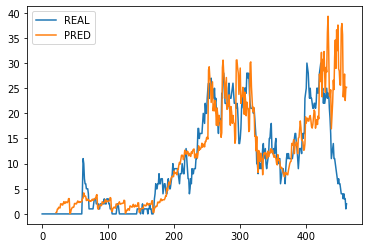

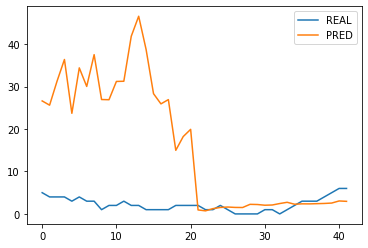

Loading... models/ingressats_total_best_model_region_vacc_mean7.28052021.6100_1.h5


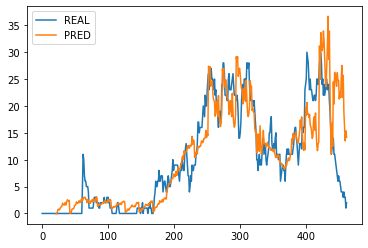

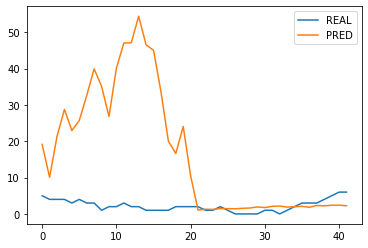

In [148]:
for cod in selCodisReg[:1]:
    
    print(cod)
    fname = "ingressats_total_best_model_region_vacc_mean7.28052021."+cod  

    #Read data
    dfAll = pd.merge(dfInc[["data",'ingressats_total_r_'+cod,'ingressats_total_r_'+cod+'_7',
                            'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7'
                           ]],
                     dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                               "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                     how="left",on="data",suffixes=("","")
                    )
    print(np.sum(dfAll.isnull(), axis=0))
    dfAll.fillna(0,inplace=True)

    #Remove last day 
    dfAll = dfAll.iloc[:-1]    
    print(dfAll.columns)

    #Convert data to format (rows,timepoints,features)
    cols = [
               'ingressats_total_r_'+cod,'ingressats_total_r_'+cod+'_7', 
               'casos_confirmat_r_'+cod,'casos_confirmat_r_'+cod+'_7',
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v1_7',
               'recompte_r_'+cod+'_v2','recompte_r_'+cod+'_v2_7'
    ]
    ncols=len(cols)
    res = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)
    THR = res.shape[0]-(21*2)    

    #Patition train/test
    train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
    train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
    test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
    test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   
    print(train_X.shape,test_X.shape)

    # normalize features
    scalers_X = []
    for i in range(train_X.shape[-1]):

        # normalize features
        scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
        train_X[:,:,i] = scaler.transform(train_X[:,:,i])
        test_X[:,:,i] = scaler.transform(test_X[:,:,i])

    scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))
    train_y = scaler_y.transform(train_y.reshape(-1,21))
    test_y = scaler_y.transform(test_y.reshape(-1,21))

    #Evaluate
    err_mse_all = []
    err_mae_all = []
    err_perc_all = []
    err_acc_all = []
    for cc in range(2):#5):

        err_mse = []
        err_mae = []
        err_perc = []
        err_acc = []
        
        print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
        model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
        tr = model.predict(train_X)
        ts = model.predict(test_X)
        
        tr_y_pred = scaler_y.inverse_transform(tr)
        tr_y_real = scaler_y.inverse_transform(train_y)        
        ts_y_pred = scaler_y.inverse_transform(ts)
        ts_y_real = scaler_y.inverse_transform(test_y)   
        
        #TRAIN
        #Show every 21 days
        tr_y_real_all = tr_y_real[[i for i in range(len(tr_y_real)) if i%21==0],:].flatten()
        tr_y_pred_all = tr_y_pred[[i for i in range(len(tr_y_pred)) if i%21==0],:].flatten()
        plt.plot(range(len(tr_y_real_all)),tr_y_real_all,label="REAL")
        plt.plot(range(len(tr_y_pred_all)),tr_y_pred_all,label="PRED")
        plt.legend()
        plt.show()

        #TEST
        #Show every 21 days
        ts_y_real_all = ts_y_real[[i for i in range(len(ts_y_real)) if i%21==0],:].flatten()
        ts_y_pred_all = ts_y_pred[[i for i in range(len(ts_y_pred)) if i%21==0],:].flatten()
        plt.plot(range(len(ts_y_real_all)),ts_y_real_all,label="REAL")
        plt.plot(range(len(ts_y_pred_all)),ts_y_pred_all,label="PRED")
        plt.legend()
        plt.show()
        